In [71]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
import seaborn as sns
sns.set_theme(color_codes=True)
from scipy import stats
import statsmodels.api as sm
import numpy as np
import json
from tqdm import tqdm_notebook 
import statsmodels.formula.api as smf

## Read the Data

In [7]:
second_session_raw_data = pd.read_csv('Data/gono-go-game-second-round.csv', index_col=0).reset_index()
# second_session_raw_data = second_session_raw_data[second_session_raw_data.recorded_at > '2022-01-18']
# second_session_raw_data = second_session_raw_data[second_session_raw_data.mturkID != 'nan' ]

num_all_experimenters = len(second_session_raw_data.mturkID.unique())
num_excluded_experimenters = 0

second_session_raw_data['correct'] = second_session_raw_data.correct == 'true'

# second_session_raw_data.head()

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (63,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Apply exclusion criteria

1. Fail the quiz of instructions more than twice.
2. Change the tab or window of the experiment.

In [8]:
experimenter_status = second_session_raw_data[second_session_raw_data.trial_type == 'survey-html-form'][['run_id','mturkID', 'exp_final_status']]
IDs_for_inclusion_by_completed = experimenter_status[experimenter_status.exp_final_status == 'fully_completed'].mturkID

run_IDs_for_exclusion_by_changing_tabs = second_session_raw_data[second_session_raw_data.exp_final_status == 'not_completed_by_changing_tab'].run_id
run_IDs_for_exclusion_by_failing_quiz = second_session_raw_data[second_session_raw_data.exp_final_status == 'not_completed_by_failing_quiz'].run_id

second_session_clean_data = second_session_raw_data[second_session_raw_data.run_id.isin(run_IDs_for_exclusion_by_changing_tabs) == False]
second_session_clean_data = second_session_clean_data[second_session_clean_data.run_id.isin(run_IDs_for_exclusion_by_failing_quiz) == False]



num_excluded_experimenters = len(second_session_raw_data.mturkID.unique()) - len(second_session_clean_data.mturkID.unique())

print("Number of participants excluded by this criterias:", num_excluded_experimenters)

Number of participants excluded by this criterias: 4


In [9]:
# exclude the first try of a turker
second_session_clean_data = second_session_clean_data[second_session_clean_data.run_id != 204 ]
second_session_clean_data = second_session_clean_data[second_session_clean_data.run_id != 14]
second_session_clean_data.mturkID.replace({"A2TLN8489YGY81_agaign": "A2TLN8489YGY81"}, inplace=True)


In [10]:
second_session_clean_data.mturkID.isna().sum()

0

3. Respond randomly, always go or never go.

    * Note: We exclude who repond randomly, always go or nogo in each 3 block

In [11]:
second_session_clean_data[second_session_clean_data.suspicious == 'true'][['mturkID', 'suspicious_type','num_gos', 'block']]

,mturkID,suspicious_type,num_gos,block
12819,A3Q1EZDNIUK41P,error_rate,36,block_3
24539,A3EYRDEQ7CXUMN,all_one,40,block_1
24780,A3EYRDEQ7CXUMN,all_one,40,block_2
25021,A3EYRDEQ7CXUMN,all_one,40,block_3
25346,A10M63DSIGIEDI,all_one,40,block_1
25828,A10M63DSIGIEDI,all_one,40,block_3
33447,A7P3R1AIA4TVV,all_one,40,block_1
33688,A7P3R1AIA4TVV,all_one,40,block_2
33929,A7P3R1AIA4TVV,all_one,40,block_3
34254,A1Q56N80RJLQ7S,all_one,40,block_1


In [12]:
susp = second_session_clean_data[second_session_clean_data.suspicious == 'true'][['mturkID', 'suspicious_type','num_gos', 'block']]

In [13]:
IDs_for_exclusion_by_random_response = list(susp.mturkID.value_counts()[ (susp.mturkID.value_counts() == 3) | (susp.mturkID.value_counts() == 2) ].index)

num_excluded_experimenters += len(IDs_for_exclusion_by_random_response)

second_session_clean_data = second_session_clean_data[second_session_clean_data.mturkID.isin(IDs_for_exclusion_by_random_response) == False]

print("Number of participants excluded by this criterias:", len(IDs_for_exclusion_by_random_response))


Number of participants excluded by this criterias: 5


In [14]:
second_session_clean_data.mturkID.isna().sum()

0

In [15]:
second_session_clean_data.mturkID.unique().shape

(125,)

4. Their rate of the correct response to detection of circle side task is less than 55%.

In [16]:
circle_side_correctness = second_session_clean_data[second_session_clean_data.choice == 'go'][['mturkID','side', 'response']]
circle_side_correctness['is_correct_circle_side'] =  (circle_side_correctness.side == circle_side_correctness.response)
accuracy_data = circle_side_correctness.groupby('mturkID').mean().reset_index()
accuracy_data.columns = ['mturkID', 'rate']
accuracy_data['is_below_55'] = accuracy_data.rate < 0.55

accuracy_data.head()


,mturkID,rate,is_below_55
0,A10BH9PYCYUKDJ,1.000000,False
1,A10JXOU89D5RXR,0.986667,False
2,A11S8IAAVDXCUS,1.000000,False
3,A12FTSX85NQ8N9,1.000000,False
4,A12HZGOZQD5YK7,1.000000,False


In [17]:
non_accurate_IDs = list(accuracy_data[accuracy_data.is_below_55 == True].mturkID)

num_excluded_experimenters += len(non_accurate_IDs)

second_session_clean_data = second_session_clean_data[second_session_clean_data.mturkID.isin(list(non_accurate_IDs)) == False]
print("Number of participants excluded by this criterias:", len(non_accurate_IDs))



Number of participants excluded by this criterias: 11


In [18]:
second_session_clean_data.mturkID.isna().sum()

0

In [19]:
second_session_clean_data[second_session_clean_data.mturkID.isna()].run_id.unique()

array([], dtype=int64)

In [20]:
second_session_clean_data.mturkID.unique().shape

(114,)

# Plot Perforance per conditions

/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_35910/3639457505.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)


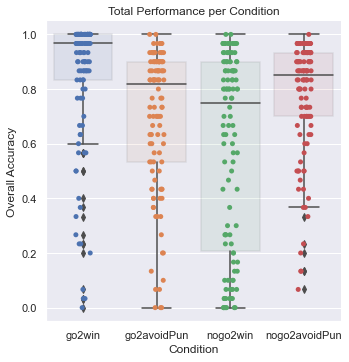

In [21]:
mapping = {'1': 'go2win', '2': 'nogo2win', '3': 'go2avoidPun', '4' : 'nogo2avoidPun'} 

circle_task_logs = second_session_clean_data[second_session_clean_data.exp_stage == 'main_target_detection']

circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)
performance_per_condition = circle_task_logs.groupby(['mturkID','cond']).mean().reset_index()
performance_per_condition.cond = performance_per_condition.cond.map(mapping)


ax = sns.catplot(x="cond", y="correct", data=performance_per_condition, order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);
ax = sns.boxplot(x="cond", y="correct", data= performance_per_condition, boxprops=dict(alpha=.1), order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);

ax.set(xlabel="Condition", ylabel = "Overall Accuracy", title = 'Total Performance per Condition')
plt.show()


# Extract Demographic datas

In [22]:
raw_demographic_data = second_session_clean_data[second_session_clean_data.trial_type == 'survey-html-form'][['mturkID', 'response']]
raw_demographic_data['gender'] = raw_demographic_data.response.apply(lambda x: x.split('"')[3])
raw_demographic_data['age'] = raw_demographic_data.response.apply(lambda x: x.split('"')[7])
raw_demographic_data['education_level'] = raw_demographic_data.response.apply(lambda x: x.split('"')[11])
raw_demographic_data['comments'] = raw_demographic_data.response.apply(lambda x: x.split('"')[15])
raw_demographic_data = raw_demographic_data.drop(['response'], axis=1)
raw_demographic_data.shape

(114, 5)

# Create final data to analyze

In [23]:
final_performace_data = performance_per_condition.pivot(index='mturkID', columns='cond', values='correct').reset_index()


final_performace_data = pd.merge(final_performace_data, accuracy_data, on='mturkID')
final_performace_data = pd.merge(final_performace_data, raw_demographic_data, on='mturkID')
final_performace_data.columns = ['mturkID', 'go2avoidPun_second_session', 'go2win_second_session', 'nogo2avoidPun_second_session', 'nogo2win_second_session', 'circle_side_performance_second_session',\
       'is_below_55_second_session', 'gender_second_session', 'age_second_session', 'education_level_second_session', 'comments_second_session']
overall_performance =  final_performace_data['nogo2win_second_session'] + \
                        final_performace_data['go2win_second_session'] + \
                        final_performace_data['nogo2avoidPun_second_session'] + \
                        final_performace_data['go2avoidPun_second_session']
final_performace_data['overall_performance'] = overall_performance/4

final_performace_data.head()

,mturkID,go2avoidPun_second_session,go2win_second_session,nogo2avoidPun_second_session,nogo2win_second_session,circle_side_performance_second_session,is_below_55_second_session,gender_second_session,age_second_session,education_level_second_session,comments_second_session,overall_performance
0,A10BH9PYCYUKDJ,0.500000,0.8,0.600000,0.266667,1.000000,False,female,41,Associate,},0.541667
1,A10JXOU89D5RXR,0.900000,1.0,0.900000,0.700000,0.986667,False,female,60,Bachelor,},0.875000
2,A11S8IAAVDXCUS,0.200000,1.0,0.633333,0.133333,1.000000,False,female,31,Associate,},0.491667
3,A12FTSX85NQ8N9,0.866667,1.0,0.966667,0.866667,1.000000,False,male,29,Bachelor,},0.925000
4,A12HZGOZQD5YK7,0.966667,1.0,0.966667,0.800000,1.000000,False,female,41,Associate,},0.933333


In [24]:
final_performace_data.shape

(114, 12)

In [25]:
final_performace_data.drop_duplicates().to_csv('Data/second_round_final_performance.csv')

# Pav axis

(0.0, 1.0)

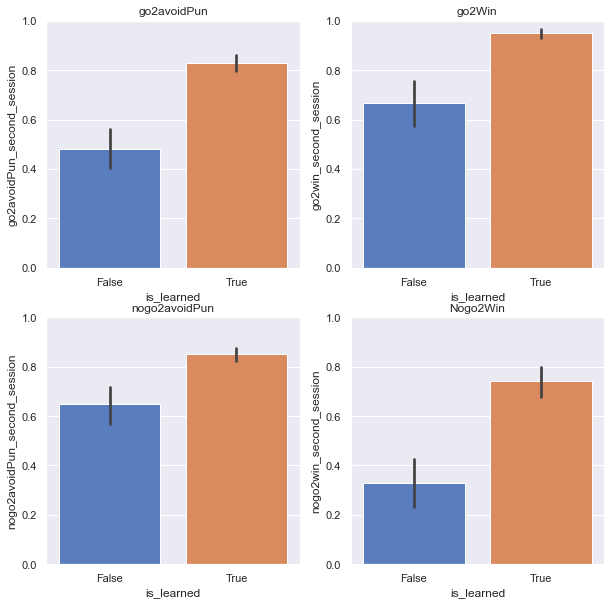

In [26]:
fig, axs = plt.subplots(ncols=2, nrows = 2, figsize=(10,10))
plt.ylim(0, 1)

final_performace_data['is_learned'] = final_performace_data.overall_performance > 0.65

sns.barplot(x="is_learned", y="nogo2win_second_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(1,1)]).set_title('Nogo2Win')

axs[1,1].set_ylim(0,1)

sns.barplot(x="is_learned", y="go2win_second_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(0,1)]).set_title('go2Win')
axs[0,1].set_ylim(0,1)



sns.barplot(x="is_learned", y="go2avoidPun_second_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(0,0)]).set_title('go2avoidPun')
axs[0,0].set_ylim(0,1)



sns.barplot(x="is_learned", y="nogo2avoidPun_second_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(1,0)]).set_title('nogo2avoidPun')
axs[1,0].set_ylim(0,1)




# modelling

In [27]:
result_of_trials = circle_task_logs[['mturkID', 'internal_node_id', 'response', 'side', 'choice', 'cond_action', 'cond_outcome','correct_action', 'outcome', 'feedback_points', 'block']].copy()

result_of_trials['stimulus'] = result_of_trials['cond_action'] + '2' + result_of_trials['cond_outcome']
result_of_trials['is_go'] = result_of_trials.choice == 'go'
result_of_trials['is_go'].replace({True: 1, False: 0}, inplace=True)


In [28]:
go2win_go_prob = pd.Series(np.zeros(30))
go2win_prob_df = pd.DataFrame()

nogo2win_go_prob = pd.Series(np.zeros(30))
nogo2win_prob_df = pd.DataFrame()

go2avoidPun_go_prob = pd.Series(np.zeros(30))
go2avoidPun_prob_df = pd.DataFrame()

nogo2avoidPun_go_prob = pd.Series(np.zeros(30))
nogo2avoidPun_prob_df = pd.DataFrame()




for mID in result_of_trials.mturkID.dropna().unique():
    go_of_every_subject = result_of_trials[result_of_trials['mturkID']== mID][['is_go','stimulus']].reset_index(drop=True)
    for s in ['go2win','nogo2win','go2avoidPun', 'nogo2avoidPun']:
        go_of_every_subject_in_s = go_of_every_subject[go_of_every_subject.stimulus == s].reset_index(drop=True)
        if( s == 'go2win'):
            go2win_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            go2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'nogo2win'):
            nogo2win_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            nogo2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'go2avoidPun'):
            go2avoidPun_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            go2avoidPun_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'nogo2avoidPun'):
            nogo2avoidPun_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            nogo2avoidPun_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()


/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_35910/3190507868.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  go2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_35910/3190507868.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  nogo2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_35910/3190507868.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

(0.0, 1.0)

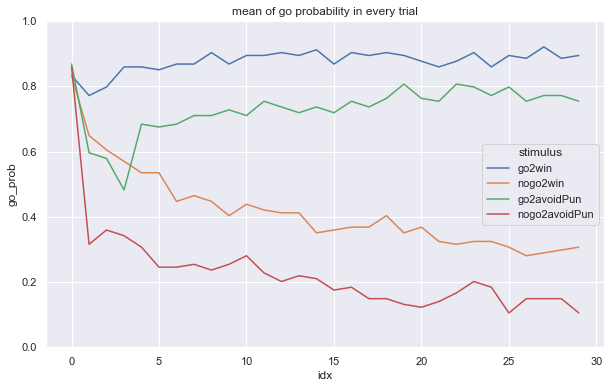

In [29]:
go_prob_df = pd.DataFrame({'go2win': go2win_go_prob, 
                            'nogo2win': nogo2win_go_prob,
                            'go2avoidPun': go2avoidPun_go_prob,\
                            'nogo2avoidPun': nogo2avoidPun_go_prob})

# go_prob_df['idx'] = go_prob_df.index

go_prob_df = go_prob_df.melt().rename(columns={'variable': 'stimulus', 'value': 'go_prob'})
go_prob_df.loc[go_prob_df.stimulus == 'go2win', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'nogo2win', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'go2avoidPun', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'nogo2avoidPun', 'idx'] = range(0,30)

plt.figure(figsize=(10,6))
ax = sns.lineplot(x="idx", y="go_prob",
             hue="stimulus", 
             data=go_prob_df)
plt.title("mean of go probability in every trial")
plt.ylim(0,1)

 

In [30]:
from sys import path
from dotenv import load_dotenv
import os
load_dotenv();

path.append(os.environ.get("MODELING_PATH"))

from fitting import ML

In [31]:
np.random.seed(30)
modeling_result_df = {}
modeling_result_df['mturkID'] = []

modeling_result_df['alpha'] = []
modeling_result_df['beta'] = []
modeling_result_df['noise'] = []
modeling_result_df['go_bias'] = []
modeling_result_df['pav_bias'] = []


def fit_subject_with_id(subject_id):
    df = result_of_trials[result_of_trials.mturkID == subject_id]
    df = df[['choice','stimulus','feedback_points']].rename(columns={'choice':'action', 'feedback_points':'reward'}).reset_index(drop=True)
    df['reward'] = pd.to_numeric(df.reward)

    max_likelihood = ML(df, optimization_method='Nelder-Mead', model_type='RW+noise+bias+Pav', initial_guess=np.random.normal(0,1,1)[0]*np.array([0.1,0.1,0.1,0.1,0.1]), without_bound=True)
    res = max_likelihood.fit_model()
    return res



In [32]:
for subject in tqdm_notebook(result_of_trials.mturkID.unique()):
    res = fit_subject_with_id(subject)

    modeling_result_df['mturkID'].append(subject)
    modeling_result_df['alpha'].append(1 / (1+ np.exp(-res.x[0])))
    modeling_result_df['beta'].append(np.exp(res.x[1]))
    modeling_result_df['noise'].append(1 / (1+ np.exp(-res.x[2])))
    modeling_result_df['go_bias'].append(res.x[3])
    modeling_result_df['pav_bias'].append(np.exp(res.x[4]))




/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_35910/2031160086.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for subject in tqdm_notebook(result_of_trials.mturkID.unique()):


  0%|          | 0/114 [00:00<?, ?it/s]

/Users/sepsad/Desktop/Stuffs/Research/goNoGo/Modelling/modelling_gng/fitting.py:34: RuntimeWarning: overflow encountered in exp
  beta = np.exp(params[1])  # sensitivity to reward
/Users/sepsad/Desktop/Stuffs/Research/goNoGo/Modelling/modelling_gng/fitting.py:75: RuntimeWarning: invalid value encountered in double_scalars
  error_Q = beta*reward - Q[stimulus][action]
/Users/sepsad/Desktop/Stuffs/Research/goNoGo/Modelling/modelling_gng/fitting.py:76: RuntimeWarning: invalid value encountered in double_scalars
  error_V = beta*reward - V[stimulus]
/Users/sepsad/Desktop/Stuffs/Research/goNoGo/Modelling/modelling_gng/fitting.py:82: RuntimeWarning: divide by zero encountered in log
  la = (q - q_max) - np.log(np.sum(np.exp(q - q_max)))
/Users/sepsad/Desktop/Stuffs/Research/goNoGo/Modelling/modelling_gng/fitting.py:79: RuntimeWarning: overflow encountered in double_scalars
  q['go'] = q['go'] + bias + pav * V[stimulus]


In [33]:
mr_df = pd.DataFrame(modeling_result_df)
mr_df['pav_bias_log'] = np.log(mr_df.pav_bias)

/opt/homebrew/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [59]:
mr_df.to_csv('./Data/modeling_result_second_session.csv')

# dist of log(pav bias)

/opt/homebrew/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pav_bias_log', ylabel='Density'>

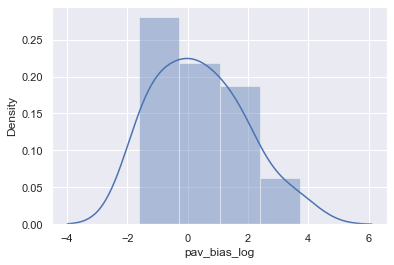

In [66]:
sns.distplot(np.log(mr_df.pav_bias_log) )

# dist of learning rate

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='alpha', ylabel='Density'>

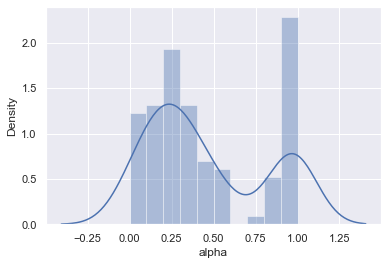

In [60]:
sns.distplot((mr_df.alpha), bins=10) 

# dist of go bias

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='go_bias', ylabel='Density'>

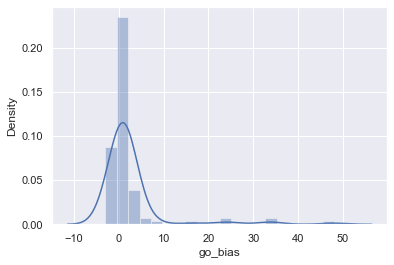

In [61]:
sns.distplot((mr_df.go_bias[mr_df.go_bias < 50]), bins=20) 

# dist of log(sensitivity to reward)

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='beta', ylabel='Density'>

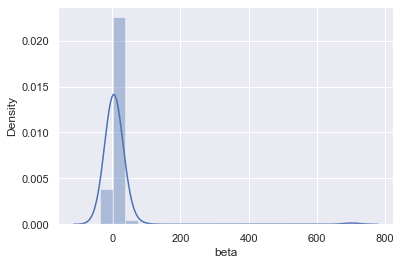

In [67]:
sns.distplot((np.log(mr_df.beta)), bins=20) 

In [68]:
mr_perf = pd.merge(mr_df, final_performace_data, on='mturkID')
mr_perf['gw_ngw'] = mr_perf.go2win_second_session - mr_perf.nogo2win_second_session


# log(pav bias) & (g2win - nogo2win) performance 

<AxesSubplot:xlabel='pav_bias_log', ylabel='gw_ngw'>

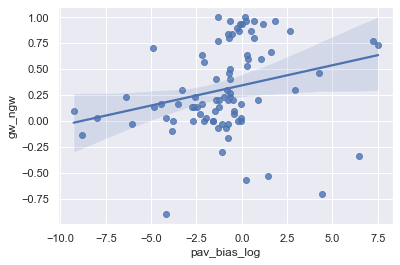

In [69]:
sns.regplot(x=('pav_bias_log'), y='gw_ngw', data = mr_perf[(mr_perf.pav_bias_log < 10) & (mr_perf.pav_bias_log > -10)])

In [72]:
smf.ols(formula = 'gw_ngw ~ pav_bias_log', data = mr_perf[(mr_perf.pav_bias_log < 10) & (mr_perf.pav_bias_log > -10)]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 gw_ngw   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     6.079
Date:                Fri, 11 Feb 2022   Prob (F-statistic):             0.0157
Time:                        12:53:34   Log-Likelihood:                -44.306
No. Observations:                  85   AIC:                             92.61
Df Residuals:                      83   BIC:                             97.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3430      0.047      7.244      0.000       0.249       0.437
pav_bias_log     0.0388      0.016      2.466      0.016       0.007       0.070
==============================================================================
Omnibus:                        4.605   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                3.842
Skew:                          -0.471   Prob(JB):                        0.146
Kurtosis:                       3.444   Cond. No.                         3.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# learning rate & (g2win - nogo2win) performance 

<AxesSubplot:xlabel='alpha', ylabel='gw_ngw'>

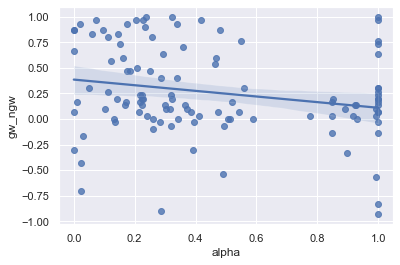

In [73]:
sns.regplot(x=(mr_perf['alpha']), y=mr_perf['gw_ngw'])

In [74]:
smf.ols(formula = 'gw_ngw ~ alpha', data = mr_perf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 gw_ngw   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     5.843
Date:                Fri, 11 Feb 2022   Prob (F-statistic):             0.0173
Time:                        12:54:02   Log-Likelihood:                -62.652
No. Observations:                 114   AIC:                             129.3
Df Residuals:                     112   BIC:                             134.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3854      0.066      5.877      0.000       0.255       0.515
alpha         -0.2756      0.114     -2.417      0.017      -0.501      -0.050
==============================================================================
Omnibus:                        1.255   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.534   Jarque-Bera (JB):                0.885
Skew:                          -0.203   Prob(JB):                        0.643
Kurtosis:                       3.147   Cond. No.                         3.55
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""